# Experiments
## Bioit set - basic ARTM with regularizers

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import artm

/tmp/ipykernel_16303/2868503476.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
artm.version()

'0.9.2'

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)

In [ ]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [13]:
def print_measures(model:list):          
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))
    
    plt.plot(range(len(model.score_tracker['SparsityPhiScore'].value)),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(len(model.score_tracker['SparsityThetaScore'].value)),
             model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    if type(model) == artm.artm_model.ARTM:
        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].contrast).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].purity).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopKernelScore Coherence'].coherence).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()
    elif type(model) == artm.hierarchy_utils.ARTM_Level:
        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].contrast).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].purity).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopKernelScore Coherence'].coherence).transpose()
#         plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print(model_artm.phi_)
print(model_artm.get_theta())

## NLP set - basic ARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)


In [ ]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(
                       topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print(model_artm.phi_)
print(model_artm.get_theta())

# Hierarchical topic models

## NLP set - hARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [ ]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [ ]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [ ]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [ ]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [ ]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [ ]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [ ]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=25)

In [ ]:
print(model_artm.get_level(0).phi_)
print(model_artm.get_level(0).get_theta())

In [ ]:
#The way to access score tracker for hARTM models
print_measures(model_artm.get_level(0))

## Bioit set - hARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 2
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [ ]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [ ]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [ ]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [ ]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [ ]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [ ]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [ ]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=25)

In [ ]:
print(model_artm.get_level(0).phi_)
print(model_artm.get_level(0).get_theta())

In [ ]:
for topic_name in model_artm.get_level(0).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(0)._score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
for topic_name in model_artm.get_level(1).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(1)._score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
#The way to access score tracker for hARTM models
print_measures(model_artm.get_level(0))

# Note on iterative training process
- This training process will serve as basis to the subsequent development of the hierarchical model
- Coherence calculation requires co-occurence to be calculated prior to modeling
    - revisit preprocessing step
- Regularizers can be added using ```model.regularizers.add```
- Regularizers can not be removed, but can be "turned-off" by setting regularization coefficient value to 0
- The general training procedure is described by Khodorchenko et al., 2020 as follows:

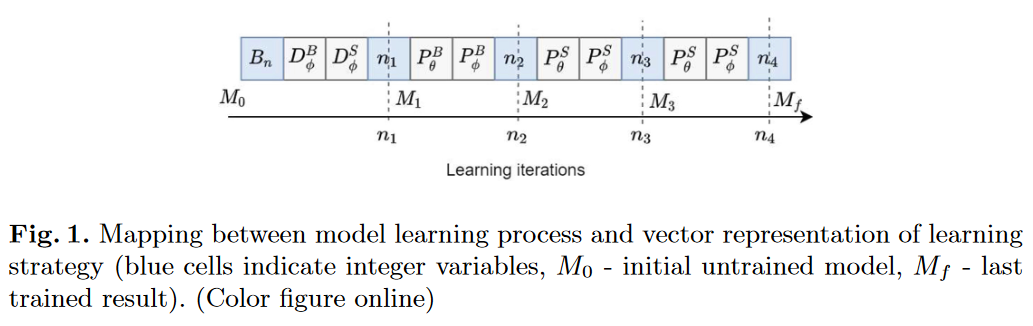

## Notation
    - B - initial number of topics
    - D - decorrelation regularizer
    - n - number of iterations
    - P - smoothing regularizers
        - B upper index - background topics
        - S upper index - specific topics
        - Phi - topics as token distributions
        - Theta - documents as topic distributions

## NLP set - iterative training

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#background and specific topics
bg_topics = [f'topic_{i}' for i in range(2)]
sp_topics = [f'topic_{i}' for i in range(2,10)]

#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 10
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
n1 = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20

In [ ]:
#First training session
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n1)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.2
model_artm.regularizers['SparsePhi'].topic_names = bg_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = bg_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n2 = 10

In [ ]:
#First training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n2)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.5
model_artm.regularizers['SparsePhi'].topic_names = sp_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = sp_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n3 = 25

In [ ]:
#Second training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n3)

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

## BIOIT set - iterative training

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#background and specific topics
bg_topics = [f'topic_{i}' for i in range(2)]
sp_topics = [f'topic_{i}' for i in range(2,10)]

#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 10
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
n1 = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20

In [ ]:
#First training session
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n1)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.2
model_artm.regularizers['SparsePhi'].topic_names = bg_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = bg_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n2 = 10

In [ ]:
#First training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n2)

In [ ]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0.5
model_artm.regularizers['SparsePhi'].topic_names = sp_topics
model_artm.regularizers['SparseTheta'].tau = 0.2
model_artm.regularizers['SparseTheta'].topic_names = sp_topics
model_artm.regularizers['DecorrelatorPhi'].tau = 0
n3 = 25

In [ ]:
#Second training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n3)

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

# Iterative training with hARTM

## NLP set

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [ ]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [ ]:
#background and specific topics
bg_topics = [f'topic_{i}' for i in range(2)]
sp_topics = [f'topic_{i}' for i in range(2,10)]

In [ ]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [ ]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [ ]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [ ]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [ ]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [ ]:
#Fit
n1 = 10
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n1)

In [ ]:
#Altering regularizers
model_artm.get_level(0).regularizers['SparsePhi'].tau = 0.2
model_artm.get_level(0).regularizers['SparsePhi'].topic_names = bg_topics
model_artm.get_level(0).regularizers['SparseTheta'].tau = 0.2
model_artm.get_level(0).regularizers['SparseTheta'].topic_names = bg_topics
model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau = 0
n2 = 10

In [ ]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n2)

In [ ]:
print_measures(level1)

In [ ]:
for topic_name in model_artm.get_level(0).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(0)._score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print_measures(level2)

In [ ]:
for topic_name in model_artm.get_level(1).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(1)._score_tracker['TopTokensScore'].last_tokens[topic_name])

# Genetic algorithm for parameter optimization
- as suggested by Khodorchenko et al., 2020

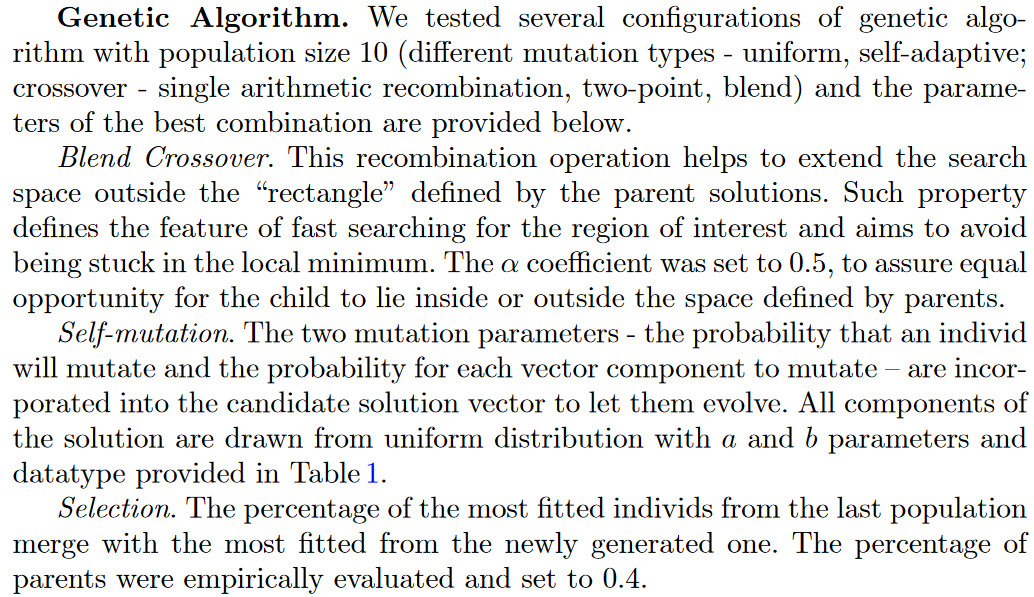

# Suggested hyperparameter boundaries for optimization

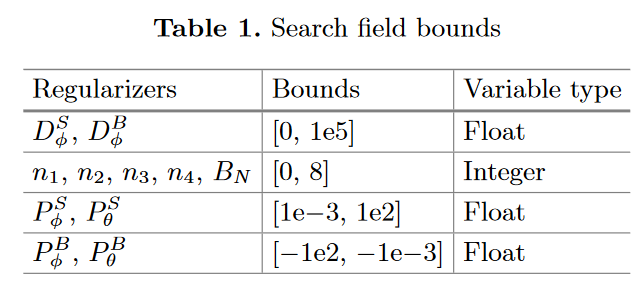

## Notation
    - B - initial number of topics
    - D - decorrelation regularizer
    - n - number of iterations
    - P - smoothing regularizers
        - B upper index - background topics
        - S upper index - specific topics
        - Phi - topics as token distributions
        - Theta - documents as topic distributions

- The GA implementation in Python is possible using the following tool:
 - https://pygad.readthedocs.io/en/latest/
 - https://pygad.readthedocs.io/en/latest/pygad_more.html#multi-objective-optimization
 - Renyi entropy should be tested for hierarchical model as proposed in https://doi.org/10.7717/peerj-cs.608.
    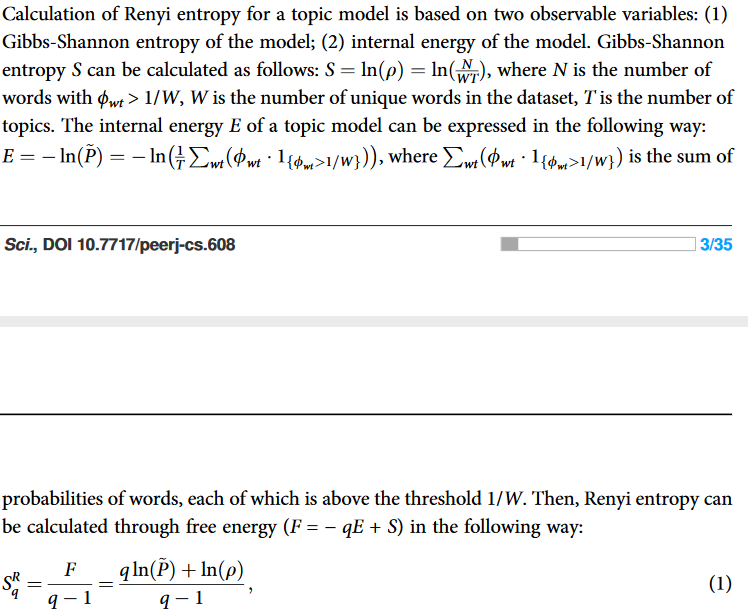

- Tutorial:
https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
- Additionally bayesian optimization could be implemented using the following algorithm:
https://github.com/bayesian-optimization/BayesianOptimization

- Fitness function for flat model based on kernel coherence:
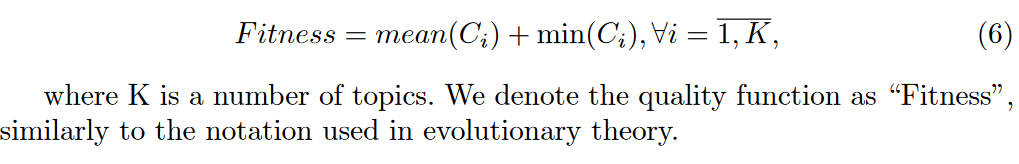

# Composing wrappers
- Model training should be repeatable as the resulting model parameters are inputs required to calculate the fitness function values.
- The same input data should be used each time
- Model structure in terms of regularizers and number of training sessions is fixed
- Parameters
    - regularization coefficients (float)
    - number of iterations in each training session (int)
    - number of background topics (int)
    - number of specific topics (int)

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [ ]:
#Number of topics
num_topics = 10
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]
num_bg_topics = 2

#defining regularizers
regularizer_names = [
    'SparsePhi',
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
]
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#Altering regularizers
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Altering regularizers
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 25

#Altering regularizers
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 25

In [ ]:
def train_flat_tm(
    batch_vectorizer:artm.BatchVectorizer,
    dictionary:artm.Dictionary, 
    scores:list,
    num_topics:int, 
    num_bg_topics:list,
    regularizers:list,
    n1:int,
    tau_dict_1:dict,
    n2:int,
    tau_dict_2:dict,
    n3:int,
    tau_dict_3:dict,
    n4:int,
    tau_dict_4:dict,
    topic_names:list = ['topic_{}'.format(i) for i in range(num_topics)],
) -> (artm.ARTM, list):
    '''Train the flat unimodal topic model using the algorithm suggested by M. Khodorchenko et al.'''
    
    #background and specific topics
    bg_topics = [f'topic_{i}' for i in range(num_bg_topics)]
    sp_topics = [f'topic_{i}' for i in range(num_bg_topics,num_topics)]
    
    
    #creating the model
    model_artm = artm.ARTM(
        topic_names  = topic_names, 
        class_ids    = {"@default_class": 1.0, "@bigram": 1.0},
        cache_theta  = True,
        scores       = scores,
        regularizers = regularizers,
        num_topics   = num_topics)
    
    #Altering regularizers for 2nd training session
    model_artm.regularizers['SparsePhi'].tau           = tau_dict_1['SparsePhi']
    model_artm.regularizers['SparseTheta'].tau         = tau_dict_1['SparseTheta']
    model_artm.regularizers['DecorrelatorPhi'].tau     = tau_dict_1['DecorrelatorPhi']
    
    #initializing the model from dictionary
    model_artm.initialize(dictionary = cooc_dict)
    
    #First training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n1)
    
    #Altering regularizers for 2nd training session
    model_artm.regularizers['SparsePhi'].tau           = tau_dict_2['SparsePhi']
    model_artm.regularizers['SparsePhi'].topic_names   = bg_topics
    model_artm.regularizers['SparseTheta'].tau         = tau_dict_2['SparseTheta']
    model_artm.regularizers['SparseTheta'].topic_names = bg_topics
    model_artm.regularizers['DecorrelatorPhi'].tau     = tau_dict_2['DecorrelatorPhi']
    
    #Second training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n2)
    
    #Altering regularizers
    model_artm.regularizers['SparsePhi'].tau           = tau_dict_3['SparsePhi']
    model_artm.regularizers['SparsePhi'].topic_names   = sp_topics
    model_artm.regularizers['SparseTheta'].tau         = tau_dict_3['SparseTheta']
    model_artm.regularizers['SparseTheta'].topic_names = sp_topics
    model_artm.regularizers['DecorrelatorPhi'].tau     = tau_dict_3['DecorrelatorPhi']
    
    #Third training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)

    #Altering regularizers
    model_artm.regularizers['SparsePhi'].tau       = tau_dict_4['SparsePhi']
    model_artm.regularizers['SparseTheta'].tau     = tau_dict_4['SparseTheta']
    model_artm.regularizers['DecorrelatorPhi'].tau = tau_dict_4['DecorrelatorPhi']
    
    #Fourth training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)
    
    #Parameter preservation
    min_fcoherence = min(model_artm.score_tracker['TopKernelScore Coherence'].coherence[-1].values())
    mean_fcoherence = model_artm.score_tracker['TopKernelScore Coherence'].average_coherence[-1]
    parameters = {
        'n':[n1,n2,n3,n4],
        'num_bg':[num_bg_topics],
        'num_topics':[num_topics],
        'SparsePhi'       : [
            tau_dict_1['SparsePhi'],
            tau_dict_2['SparsePhi'],
            tau_dict_3['SparsePhi'],
            tau_dict_4['SparsePhi']
        ],
        'SparseTheta'     : [
            tau_dict_1['SparseTheta'],
            tau_dict_2['SparseTheta'],
            tau_dict_3['SparseTheta'],
            tau_dict_4['SparseTheta']
        ],
        'DecorrelatorPhi' : [
            tau_dict_1['DecorrelatorPhi'],
            tau_dict_2['DecorrelatorPhi'],
            tau_dict_3['DecorrelatorPhi'],
            tau_dict_4['DecorrelatorPhi']
        ] 
    }
    fitness = min_fcoherence + mean_fcoherence
    flat_params = sum(list(parameters.values()),[])
    return model_artm, flat_params, fitness

In [ ]:
model, parameters, score = train_flat_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    num_topics = num_topics, 
    topic_names = topic_names,
    num_bg_topics = num_bg_topics,
    regularizers = regularizers,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

In [ ]:
score

# Trying optimization with genetic algorithm

In [ ]:
import pygad
import numpy as np

def decode_solution(solution):
    # The first 6 genes are integers
    integer_params = [int(gene) for gene in solution[:6]]
    
    # The remaining genes are floating-point numbers for regularization coefficients
    float_params = solution[6:]
    
    # Assuming the order of parameters in the chromosome matches their order in the train_flat_tm function
    # Unpack integer_params for readability (adjust according to your parameter structure)
    n1, n2, n3, n4, num_bg_topics,num_topics = integer_params
    
    # Return the unpacked parameters
    # float_params are returned as is, assuming train_flat_tm expects them as a list or similar structure
    return n1, n2, n3, n4, num_bg_topics,num_topics, float_params


def fitness_function(ga_instance, solution, solution_idx):
    n1, n2, n3, n4, num_bg_topics, num_topics, float_params = decode_solution(solution)
    
    # Assuming train_flat_tm and other required variables (like batch_vectorizer, cooc_dict, etc.) are defined elsewhere
    model, parameters, score = train_flat_tm(
        batch_vectorizer=batch_vectorizer,
        dictionary=cooc_dict,
        scores=scores,
        num_topics=num_topics,
        topic_names=topic_names,
        num_bg_topics = num_bg_topics,
        regularizers=regularizers,
        n1=n1,
        tau_dict_1=dict(zip(regularizer_names, [float_params[i] for i in [0, 3, 8]])),
        n2=n2,
        tau_dict_2=dict(zip(regularizer_names, [float_params[i] for i in [1, 4, 9]])),
        n3=n3,
        tau_dict_3=dict(zip(regularizer_names, [float_params[i] for i in [2, 5, 10]])),
        n4=n4,
        tau_dict_4=dict(zip(regularizer_names, [float_params[i] for i in [3, 6, 11]]))
    )
    return score

In [ ]:
#Defining constraints on parameter values
int_gene_space = [{'low': 0, 'high': 8}]*6
float_gene_space = [
    {'low': 0, 'high': 0},
    {'low': -0.01, 'high': -0.001},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.001, 'high': 1e2},
    {'low': -0.01, 'high': -0.001},
    {'low': -0.01, 'high': -0.001},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
]
gene_space = int_gene_space + float_gene_space

In [ ]:
def on_generation(ga_instance):
    current_generation = ga_instance.generations_completed
    best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
    print(f"Generation {current_generation}: Best Fitness = {best_solution_fitness}")


In [ ]:
ga_instance = pygad.GA(
    num_generations=1,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=18,  # 6 integer + 12 float parameters
    gene_space=gene_space,
    parent_selection_type="rank",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10,
    allow_duplicate_genes=False,
    on_generation=on_generation,
)

In [ ]:
%%time
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Solution: {solution}, Fitness: {solution_fitness}")

In [ ]:
model, parameters, score = train_flat_tm(
        batch_vectorizer=batch_vectorizer,
        dictionary=cooc_dict,
        scores=scores,
        num_topics=int(solution[4]),
        topic_names=topic_names,
        num_bg_topics = int(solution[5]),
        regularizers=regularizers,
        n1=int(solution[0]),
        tau_dict_1=dict(zip(regularizer_names, [solution[6:][i] for i in [0, 3, 8]])),
        n2=int(solution[1]),
        tau_dict_2=dict(zip(regularizer_names, [solution[6:][i] for i in [1, 4, 9]])),
        n3=int(solution[2]),
        tau_dict_3=dict(zip(regularizer_names, [solution[6:][i] for i in [2, 5, 10]])),
        n4=int(solution[3]),
        tau_dict_4=dict(zip(regularizer_names, [solution[6:][i] for i in [3, 6, 11]]))
    )

In [ ]:
print_measures(model)

# Attempting to use Renyi entropy to figure out optimal number of topics in each layer (need to implement optimization over number of topics)

### Renyi entropy calculation

In [ ]:
import numpy as np

level_1_phi = model.get_level(0).get_phi()
l1phi_np = level_1_phi.to_numpy()

W = int(str(cooc_dict).split(" ")[-1][:-1].split("=")[-1])

T = topics_per_level[0]


p_uniform = 1/W
phi_non_uniform = l1phi_np[l1phi_np > p_uniform]
N = len(phi_non_uniform)

S = np.log(N/(W*T))

E = -np.log((1/T)*np.sum(phi_non_uniform))

q = 1/T

S_qR = (-q*E+S)/(q-1)

S_qR

In [3]:
def get_renyi_entropy(model, dictionary, num_topics):
    '''Function to calculate renyi entropy for topic model
    based on  https://doi.org/10.7717/peerj-cs.608'''
    import numpy as np
    #Getting token distribution for each topic
    phi = model.get_phi()
    phi_np = phi.to_numpy()
    
    #Getting number of words in the dictionary
    W = int(str(dictionary).split(" ")[-1][:-1].split("=")[-1])
    
    #Calculating uniform distribution threshold value
    p_uniform = 1/W
    
    #Filtering the phi_wt matrix based on threshold
    phi_gt_uniform = phi_np[phi_np > p_uniform]
    
    #Getting number of entries above threshold
    N = len(phi_gt_uniform)
    
    #Getting number of topics in the model
    T = num_topics
    
    #Calculating Gibbs-Shannon entropy
    S = np.log(N/(W*T))
    
    #Calculating internal energy
    E = -np.log((1/T)*np.sum(phi_gt_uniform))
    
    #Calculating deformation parameter
    q = 1/T
    
    #Calculating Renyi entropy value
    S_qR = (-q*E+S)/(q-1)
    return S_qR

In [ ]:
get_renyi_entropy(model.get_level(0), cooc_dict, topics_per_level[0])

### Model wrapper and training

In [64]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [65]:
#Number of topics
num_levels = 4
topics_per_level = [2, 4, 8, 16] #should be increasing with index

#defining regularizers
regularizer_names = [
    'SparsePhi',
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5),
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=0),
    artm.TopicSelectionThetaRegularizer(name='TopicDecorr',tau=0)
]
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Altering regularizers
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Altering regularizers
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Altering regularizers
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [66]:
def train_hier_tm(
    batch_vectorizer:artm.BatchVectorizer,
    dictionary:artm.Dictionary, 
    scores:list,
    regularizers:list,
#     num_topics:int, 
#     num_bg_topics:list,
    num_levels:int,
    topics_per_level:list,
    n1:int,
    tau_dict_1:dict,
    n2:int,
    tau_dict_2:dict,
    n3:int,
    tau_dict_3:dict,
    n4:int,
    tau_dict_4:dict,
#     topic_names:list = ['topic_{}'.format(i) for i in range(num_topics)],
) -> (artm.ARTM, list):
    '''Train the flat unimodal topic model using the algorithm suggested by M. Khodorchenko et al.'''
    
    #background and specific topics
#     bg_topics = [f'topic_{i}' for i in range(num_bg_topics)]
#     sp_topics = [f'topic_{i}' for i in range(num_bg_topics,num_topics)]
    
    
    #creating the model
    model_artm = artm.hARTM(
        regularizers = regularizers,
        scores=scores,
        cache_theta=True
    )
    
    
    #Adding multiple levels to the model
    level_dict = {}
    for i in range(num_levels):
        level_id = f'level_{i}'
        #Add level
        level_dict[level_id] = model_artm.add_level(
            num_topics=topics_per_level[i],
            parent_level_weight = 0.5
        )

        #Initialize
        level_dict[level_id].initialize(dictionary = cooc_dict)
        level_dict[level_id].fit_offline(
            batch_vectorizer      = batch_vectorizer, 
            num_collection_passes = 1)
        
    
    #Altering regularizers for 2nd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_1['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_1['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_1['DecorrelatorPhi']
    
    #First training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n1)
    
    #Altering regularizers for 2nd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_2['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_2['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_2['DecorrelatorPhi']
    
    #Second training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n2)
    
    #Altering regularizers
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_3['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_3['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_3['DecorrelatorPhi']
    
    #Third training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)

    #Altering regularizers
    model_artm.get_level(0).regularizers['SparsePhi'].tau       = tau_dict_4['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau     = tau_dict_4['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau = tau_dict_4['DecorrelatorPhi']
    
    #Fourth training session
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)
    
    #Calculating Renyi entropy for each level
    S_qR_dict = {}
    mean_S_qR = 0
    for i in range(num_levels):
        level_id = f'level_{i}'
        level = level_dict[level_id]
        S_qR = get_renyi_entropy(
            model=level, 
            dictionary=dictionary,
            num_topics=topics_per_level[i]
        )
        S_qR_dict[f'{level_id}'] = S_qR
        #Average Renyi entropy accross levels to use in score calculation
        mean_S_qR += S_qR/num_levels
    
    #Parameter preservation
    parameters = {
#         'n':[n1,n2,n3,n4],
#         'num_bg':[num_bg_topics],
#         'num_topics':[num_topics],
        'topics_per_level':topics_per_level,
        'SparsePhi'       : [
            tau_dict_1['SparsePhi'],
            tau_dict_2['SparsePhi'],
            tau_dict_3['SparsePhi'],
            tau_dict_4['SparsePhi']
        ],
        'SparseTheta'     : [
            tau_dict_1['SparseTheta'],
            tau_dict_2['SparseTheta'],
            tau_dict_3['SparseTheta'],
            tau_dict_4['SparseTheta']
        ],
        'DecorrelatorPhi' : [
            tau_dict_1['DecorrelatorPhi'],
            tau_dict_2['DecorrelatorPhi'],
            tau_dict_3['DecorrelatorPhi'],
            tau_dict_4['DecorrelatorPhi']
        ],
    }
    
    #Generating parameter list
    flat_params = sum(list(parameters.values()),[])    
    
    #Calculating score for the whole model
    min_fc_list = []
    mean_fc_list = []
    for i in range(num_levels):
        min_fc_list.append(min(model_artm.get_level(i)._score_tracker['TopKernelScore Coherence'].coherence[-1].values()))
        mean_fc_list.append(model_artm.get_level(0)._score_tracker['TopKernelScore Coherence'].average_coherence[-1])
    min_fcoherence = np.array(min_fc_list)
    mean_fcoherence = np.array(mean_fc_list)
    fitness = min_fcoherence + mean_fcoherence
        
    return model_artm, flat_params, fitness, parameters, S_qR_dict

In [67]:
%%time
model, flat_parameters, score, parameters, S_qR_dict = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

CPU times: user 1min 26s, sys: 39.7 s, total: 2min 6s
Wall time: 32.8 s


In [68]:
score

array([1.74786907, 2.1610322 , 1.82722312, 2.11779785])

In [72]:
S_qR_dict

{'level_0': 3.5688171341992416,
 'level_1': 2.4007321275749463,
 'level_2': 2.0468529160104896,
 'level_3': 2.308409253298952}

In [ ]:
flat_parameters

In [70]:
parameters

{'topics_per_level': [2, 4, 8, 16],
 'SparsePhi': [0, 0.5, 0.5, 0.5],
 'SparseTheta': [0, 0.2, 0.2, 0.2],
 'DecorrelatorPhi': [250000.0, 0, 0, 0]}

In [71]:
for i in range(num_levels):
    print(f'level{i}')
    for topic_name in model.get_level(i).topic_names:
        print(
            topic_name + ': ', model.get_level(i).score_tracker['TopTokensScore'].last_tokens[topic_name])

level0
topic_0:  ['data', 'network', 'social', 'used', 'learning', 'spam', 'information', 'embedding', 'networks', 'research']
topic_1:  ['model', 'proceedings', 'conference', 'information', 'learning', 'knowledge', 'text', 'language', 'data', 'methods']
level1
topic_0:  ['data', 'network', 'embedding', 'information', 'news', 'graph', 'clustering', 'learning', 'models', 'networks']
topic_1:  ['clinical', 'social', 'patent', 'text', 'model', 'classification', 'data', 'spam', 'learning', 'detection']
topic_2:  ['knowledge', 'model', 'articles', 'tax', 'used', 'training', 'disease', 'set', 'research', 'quality']
topic_3:  ['proceedings', 'conference', 'language', 'extraction', 'computational', 'knowledge', 'association', 'linguistics', 'learning', 'methods']
level2
topic_0:  ['clustering', 'areas', 'topic', 'institutions', 'recommendation', 'terms', 'thematic', 'technology', 'performance', 'number']
topic_1:  ['model', 'text', 'information', 'used', 'models', 'using', 'clinical', 'confere

In [84]:
#getting document embeddings for a given level
model.get_level(3).get_theta()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
topic_0,0.000251,0.000074,0.000283,0.000127,0.000291,0.000135,0.000508,0.000213,0.000096,0.000142,...,0.000062,0.000171,0.000286,0.000081,0.000065,0.001242,0.000186,0.000233,0.000134,0.000264
topic_1,0.000245,0.000059,0.000560,0.000106,0.001265,0.000098,0.000372,0.000168,0.000086,0.000137,...,0.000052,0.000138,0.000242,0.000078,0.000073,0.001146,0.000118,0.000162,0.000109,0.000189
topic_2,0.000340,0.000094,0.000304,0.000169,0.000594,0.000219,0.007482,0.000226,0.000319,0.000206,...,0.000130,0.000283,0.000300,0.000236,0.000222,0.005809,0.001861,0.000314,0.980911,0.000286
topic_3,0.001073,0.000074,0.000813,0.985803,0.000462,0.000153,0.007986,0.000378,0.000111,0.000209,...,0.000088,0.000216,0.000812,0.000207,0.000605,0.813522,0.000248,0.000191,0.000277,0.000955
topic_4,0.175987,0.005580,0.001316,0.011906,0.193643,0.000415,0.087126,0.000300,0.676492,0.003253,...,0.004999,0.000668,0.000242,0.034937,0.172441,0.072854,0.184365,0.002968,0.016185,0.007975
topic_5,0.000360,0.000098,0.000341,0.000168,0.788035,0.994320,0.129123,0.002228,0.000136,0.000193,...,0.000131,0.000632,0.001277,0.962138,0.000352,0.002418,0.000522,0.000223,0.000199,0.000730
topic_6,0.000287,0.000096,0.000373,0.000159,0.001157,0.000492,0.000935,0.000235,0.000127,0.992645,...,0.000071,0.000165,0.000259,0.000108,0.000452,0.001786,0.000164,0.000206,0.000146,0.000158
topic_7,0.000307,0.000082,0.000325,0.000152,0.001796,0.000184,0.003099,0.993608,0.000114,0.000162,...,0.000064,0.000568,0.001468,0.000098,0.000110,0.023613,0.000292,0.000195,0.000164,0.000266
topic_8,0.000360,0.000081,0.000610,0.000146,0.000495,0.000113,0.000648,0.000198,0.000578,0.000182,...,0.000067,0.000154,0.962170,0.000349,0.818732,0.002181,0.000200,0.000251,0.000170,0.000218
topic_9,0.818763,0.000078,0.004945,0.000156,0.000409,0.000115,0.000463,0.000221,0.000106,0.000239,...,0.000060,0.000168,0.000739,0.000172,0.000136,0.001418,0.000155,0.000182,0.000157,0.000147


Sparsity Phi: 0.570 
Sparsity Theta: 0.000
Kernel contrast: 0.827
Kernel purity: 0.780


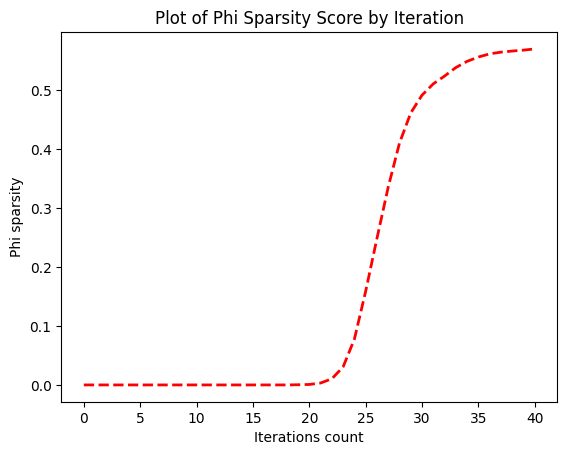

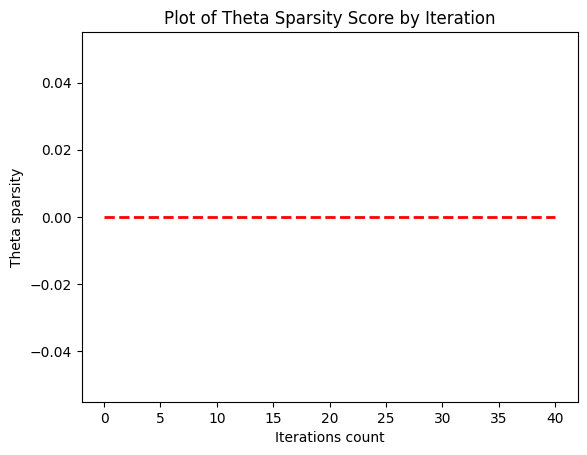

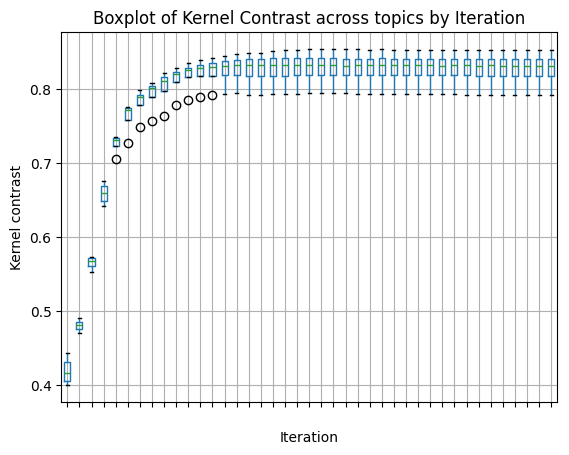

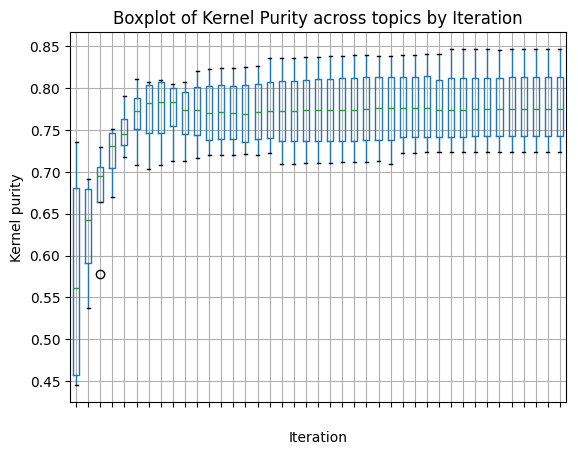

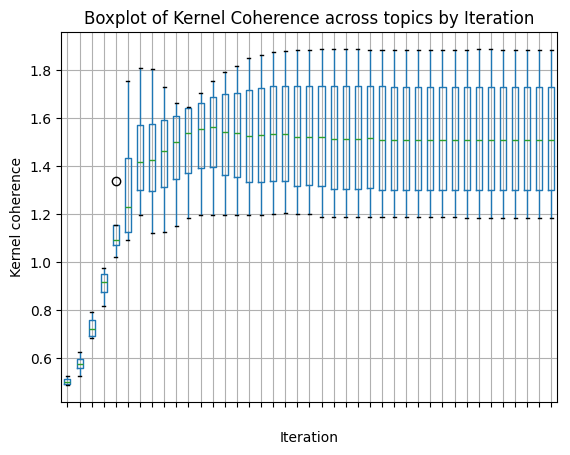

# Attempting to use genetic algorithm for parameter optimization (too slow)

In [86]:
#getting topic embeddings for parent level
model.get_level(3).get_theta()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
topic_0,0.000251,0.000074,0.000283,0.000127,0.000291,0.000135,0.000508,0.000213,0.000096,0.000142,...,0.000062,0.000171,0.000286,0.000081,0.000065,0.001242,0.000186,0.000233,0.000134,0.000264
topic_1,0.000245,0.000059,0.000560,0.000106,0.001265,0.000098,0.000372,0.000168,0.000086,0.000137,...,0.000052,0.000138,0.000242,0.000078,0.000073,0.001146,0.000118,0.000162,0.000109,0.000189
topic_2,0.000340,0.000094,0.000304,0.000169,0.000594,0.000219,0.007482,0.000226,0.000319,0.000206,...,0.000130,0.000283,0.000300,0.000236,0.000222,0.005809,0.001861,0.000314,0.980911,0.000286
topic_3,0.001073,0.000074,0.000813,0.985803,0.000462,0.000153,0.007986,0.000378,0.000111,0.000209,...,0.000088,0.000216,0.000812,0.000207,0.000605,0.813522,0.000248,0.000191,0.000277,0.000955
topic_4,0.175987,0.005580,0.001316,0.011906,0.193643,0.000415,0.087126,0.000300,0.676492,0.003253,...,0.004999,0.000668,0.000242,0.034937,0.172441,0.072854,0.184365,0.002968,0.016185,0.007975
topic_5,0.000360,0.000098,0.000341,0.000168,0.788035,0.994320,0.129123,0.002228,0.000136,0.000193,...,0.000131,0.000632,0.001277,0.962138,0.000352,0.002418,0.000522,0.000223,0.000199,0.000730
topic_6,0.000287,0.000096,0.000373,0.000159,0.001157,0.000492,0.000935,0.000235,0.000127,0.992645,...,0.000071,0.000165,0.000259,0.000108,0.000452,0.001786,0.000164,0.000206,0.000146,0.000158
topic_7,0.000307,0.000082,0.000325,0.000152,0.001796,0.000184,0.003099,0.993608,0.000114,0.000162,...,0.000064,0.000568,0.001468,0.000098,0.000110,0.023613,0.000292,0.000195,0.000164,0.000266
topic_8,0.000360,0.000081,0.000610,0.000146,0.000495,0.000113,0.000648,0.000198,0.000578,0.000182,...,0.000067,0.000154,0.962170,0.000349,0.818732,0.002181,0.000200,0.000251,0.000170,0.000218
topic_9,0.818763,0.000078,0.004945,0.000156,0.000409,0.000115,0.000463,0.000221,0.000106,0.000239,...,0.000060,0.000168,0.000739,0.000172,0.000136,0.001418,0.000155,0.000182,0.000157,0.000147


In [85]:
#getting topic-term distributions
model.get_level(3).get_phi()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
afu,0.000115,0.000100,0.000072,0.000088,0.000033,0.000038,0.000092,0.000070,0.000029,0.000764,0.000037,0.000049,0.000051,0.000083,0.000045,0.000091
aimed,0.000118,0.000112,0.000081,0.000097,0.000077,0.000042,0.000091,0.000075,0.000266,0.000818,0.000041,0.000058,0.000056,0.000091,0.000047,0.000095
algorithms,0.000141,0.000131,0.000097,0.001695,0.000103,0.000750,0.002602,0.000112,0.000046,0.001091,0.000054,0.000081,0.005784,0.000119,0.007386,0.001211
also,0.001988,0.000130,0.007099,0.000127,0.001711,0.002954,0.002267,0.002192,0.008569,0.000732,0.002724,0.004475,0.000682,0.001530,0.001456,0.003965
annotation,0.000137,0.000127,0.000110,0.004257,0.001700,0.001417,0.000112,0.000098,0.002520,0.007547,0.000048,0.000093,0.000063,0.000646,0.000201,0.002394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
traf,0.000136,0.000135,0.000097,0.000113,0.000045,0.000051,0.000108,0.000095,0.000042,0.000113,0.008776,0.000076,0.000074,0.000108,0.000056,0.000107
transport,0.000129,0.000123,0.000090,0.000106,0.000040,0.000047,0.000115,0.000086,0.000037,0.000105,0.002280,0.000062,0.000075,0.000109,0.000061,0.000114
transportation,0.000137,0.000108,0.000085,0.000099,0.000052,0.000052,0.000117,0.000085,0.000039,0.000110,0.003207,0.000059,0.000076,0.000103,0.000065,0.000129
vehicular,0.000104,0.000106,0.000070,0.000085,0.000028,0.000036,0.000086,0.000070,0.000029,0.000085,0.000331,0.000051,0.000054,0.000085,0.000044,0.000085


# Attempt to optimize the number of topics in each layer and the coefficients for regularizers in different iterations of Genetic Algorithm (as if they do no depend on each-other).

In [29]:
def on_generation(ga_instance):
    current_generation = ga_instance.generations_completed
    best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
    print(f"Generation {current_generation}: Best Fitness = {best_solution_fitness}")


In [28]:
#Defining constraints on parameter values
int_gene_space = [{'low': 5, 'high': 10}]*num_levels #[{'low': 0, 'high': 5}]*4 + 
float_gene_space = [
    {'low': 0, 'high': 0},
    {'low': -0.01, 'high': -0.001},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.001, 'high': 1e2},
    {'low': -0.01, 'high': -0.001},
    {'low': -0.01, 'high': -0.001},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.001, 'high': 1e2},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
    {'low': 0.0, 'high': 1e5},
]
gene_space = int_gene_space + float_gene_space

In [27]:
import pygad
import numpy as np

def decode_solution(solution):
    # The first 6 genes are integers
#     integer_params = [int(gene) for gene in solution[:4]]
    
    # Assuming the order of parameters in the chromosome matches their order in the train_flat_tm function
    # Unpack integer_params for readability (adjust according to your parameter structure)
#     n1, n2, n3, n4 = integer_params
    
    
    #Number of topics per level
    nt_per_level = []
    for i in range(num_levels):
        nt_per_level.append(int(solution[i]))
    
    # The remaining genes are floating-point numbers for regularization coefficients
    float_params = solution[num_levels:]
    
    # Return the unpacked parameters
    # float_params are returned as is, assuming train_flat_tm expects them as a list or similar structure
    return nt_per_level, float_params #, n1, n2, n3, n4,


def fitness_function(ga_instance, solution, solution_idx):
    topics_per_level, float_params = decode_solution(solution) # n1, n2, n3, n4,
    
    model, flat_parameters, score, parameters = train_hier_tm(
        batch_vectorizer = batch_vectorizer,
        dictionary = cooc_dict, 
        scores = scores, 
        regularizers = regularizers,
        num_levels=num_levels,
        topics_per_level=topics_per_level,
        n1=n1,
        tau_dict_1=dict(zip(regularizer_names, [float_params[i] for i in [0, 3, 8]])),
        n2=n2,
        tau_dict_2=dict(zip(regularizer_names, [float_params[i] for i in [1, 4, 9]])),
        n3=n3,
        tau_dict_3=dict(zip(regularizer_names, [float_params[i] for i in [2, 5, 10]])),
        n4=n4,
        tau_dict_4=dict(zip(regularizer_names, [float_params[i] for i in [3, 6, 11]]))
    )
    return score

In [30]:
ga_instance = pygad.GA(
    num_generations=1,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=12+num_levels,  # 6 integer + 12 float parameters
    gene_space=gene_space,
    parent_selection_type="rank",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10,
    allow_duplicate_genes=False,
    on_generation=on_generation,
)

/home/omegatro/anaconda3/envs/msc_project/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [31]:
%%time
ga_instance.run()

/home/omegatro/anaconda3/envs/msc_project/lib/python3.9/site-packages/artm/hierarchy_utils.py:257: UserWarning: Adding level with num_topics = 6 less or equal than parent level's num_topics = 6
  warnings.warn("Adding level with num_topics = %s less or equal than parent level's num_topics = %s" %
/home/omegatro/anaconda3/envs/msc_project/lib/python3.9/site-packages/artm/hierarchy_utils.py:257: UserWarning: Adding level with num_topics = 6 less or equal than parent level's num_topics = 6
  warnings.warn("Adding level with num_topics = %s less or equal than parent level's num_topics = %s" %
/home/omegatro/anaconda3/envs/msc_project/lib/python3.9/site-packages/artm/hierarchy_utils.py:257: UserWarning: Adding level with num_topics = 6 less or equal than parent level's num_topics = 9
  warnings.warn("Adding level with num_topics = %s less or equal than parent level's num_topics = %s" %
/home/omegatro/anaconda3/envs/msc_project/lib/python3.9/site-packages/artm/hierarchy_utils.py:257: UserWar

KeyboardInterrupt: 

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Solution: {solution}, Fitness: {solution_fitness}")

/home/omegatro/anaconda3/envs/msc_project/lib/python3.9/site-packages/artm/hierarchy_utils.py:257: UserWarning: Adding level with num_topics = 6 less or equal than parent level's num_topics = 6
  warnings.warn("Adding level with num_topics = %s less or equal than parent level's num_topics = %s" %
/home/omegatro/anaconda3/envs/msc_project/lib/python3.9/site-packages/artm/hierarchy_utils.py:257: UserWarning: Adding level with num_topics = 6 less or equal than parent level's num_topics = 6
  warnings.warn("Adding level with num_topics = %s less or equal than parent level's num_topics = %s" %


# Attemp to apply spectral clustering based on the image using document and topic embeddings from hierarchical model